# Understanding feature interactions with SHAP : sklearn's RandomForestRegressor

In [1]:
import pandas
import sklearn
import scipy
from sklearn import model_selection, linear_model, preprocessing, metrics, ensemble
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from scipy import cluster
from scipy.cluster import hierarchy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
rxns_df = pandas.read_csv("godineau2023_reactions_with_yields.tsv", sep='\t')
rxns_df_x = rxns_df.drop("Yield of 3aa", axis = 1)
rxns_df_x = rxns_df_x.drop("Conversion of 1a", axis = 1)
rxns_df_y = rxns_df[["Yield of 3aa"]]

In [3]:
numerical_features = rxns_df_x.select_dtypes(include=['int','float']).columns
categorical_features = rxns_df_x.select_dtypes(include=['object']).columns
label_encoders={}
for feature in categorical_features:
    label_encoders[feature]=LabelEncoder()
    rxns_df_x[feature] = label_encoders[feature].fit_transform(rxns_df_x[feature])
#prepping y
numerical_features_y = rxns_df_y.select_dtypes(include=['int','float']).columns
categorical_features_y = rxns_df_y.select_dtypes(include=['object']).columns
label_encoders_y={}
for feature in categorical_features_y:
    label_encoders[feature]=LabelEncoder()
    rxns_df_y[feature] = label_encoders_y[feature].fit_transform(rxns_df_y[feature])
x_train, x_temp, y_train, y_temp = train_test_split(rxns_df_x, rxns_df_y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5,random_state=42)

In [4]:
model = RandomForestRegressor(random_state=42)
model.fit(x_train, y_train)

C:\Users\Public.utilisateur\AppData\Local\Temp\ipykernel_9064\1165176309.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


RandomForestRegressor(random_state=42)

In [25]:
y_train

,Yield of 3aa
236,10.83
159,85.51
146,73.58
69,0.41
2,0.00
...,...
20,10.92
188,0.00
71,10.77
106,34.51


In [5]:
#validation
y_val_pred = model.predict(x_val)
#accuracy = model.score(y_val_pred, y_val)
accuracy = r2_score(y_val, y_val_pred)
print(f'Validation Accuracy with r2 :{accuracy}')
MAE_val = mean_absolute_error(y_val, y_val_pred)
RMSE_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f"Validation RMSE:{RMSE_val}")
print(f'Validation MAE:{MAE_val}')

#testing
y_test_pred = model.predict(x_test)
accuracy_test = r2_score(y_test, y_test_pred)
#accuracy_test = model.score(y_test_pred, y_test)
print(f'Test Set Accuracy with r2 : {accuracy_test}')
MAE_test = mean_absolute_error(y_test, y_test_pred)
RMSE_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Test RMSE:{RMSE_test}")
print(f'Test MAE:{MAE_test}')

Validation Accuracy with r2 :0.5538779963315477
Validation RMSE:13.65557371711273
Validation MAE:10.216600000000003
Test Set Accuracy with r2 : 0.6736592356581093
Test RMSE:12.303904143888635
Test MAE:9.722370000000002


Already we can see that the accuracy here is higher than for the previous models (linear regression, additive model)

In [6]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [7]:
explainer = shap.Explainer(model, x_train)
shap_values = explainer(x_val, check_additivity=False)

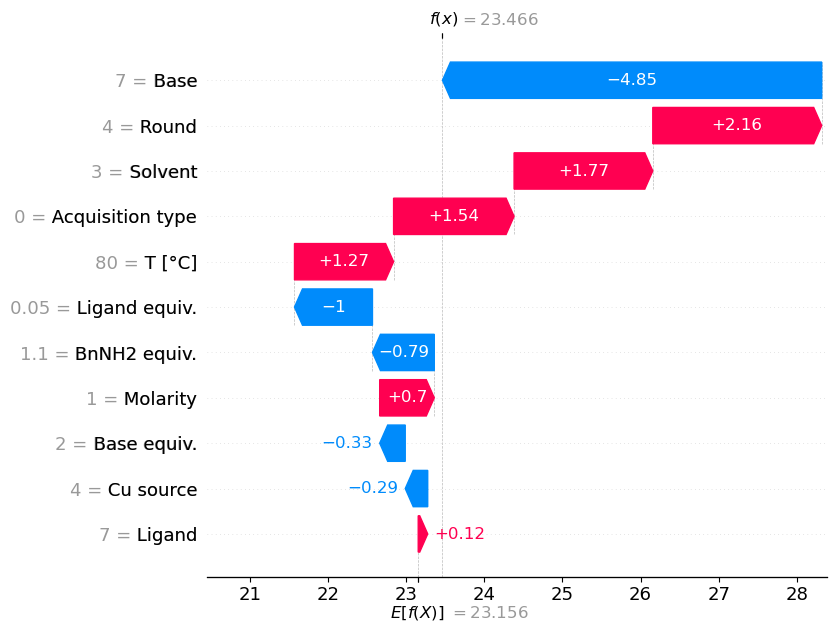

In [8]:
shap.plots.waterfall(shap_values[0], max_display=11)

Seeing the round have such a big influence makes sense here, it's what we expect with the experiment.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


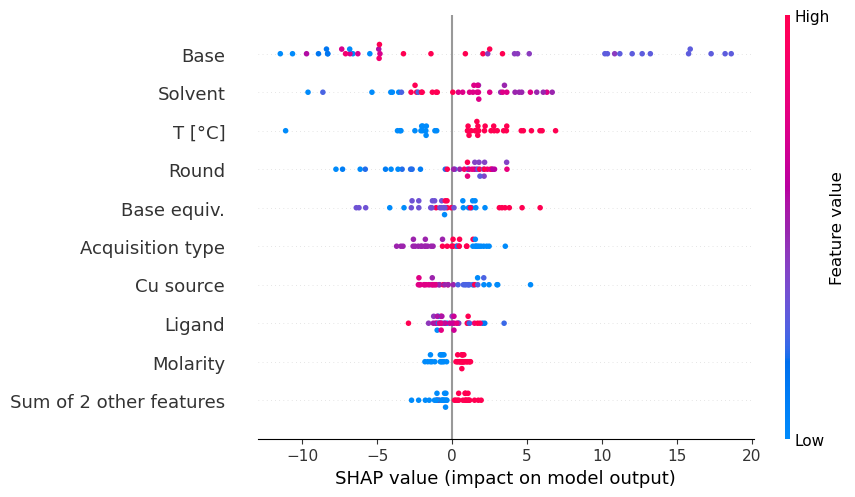

In [9]:
shap.plots.beeswarm(shap_values)

The two lowest SHAP values are those of the ligand equivalent and BnNH2 equivalent. This is different from both GAM and LR, but qualitatively the information is the same.

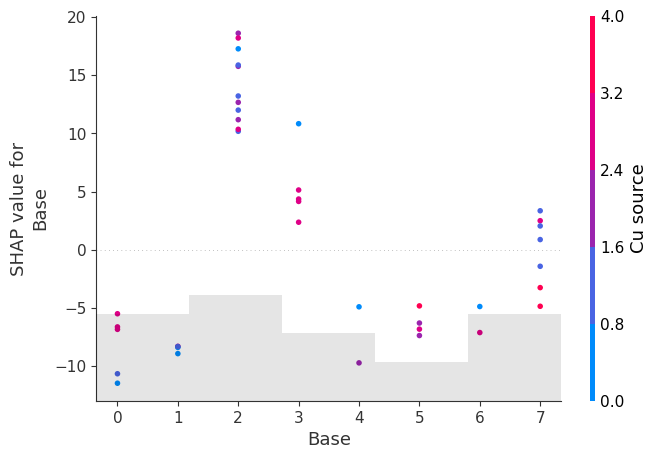

In [10]:
shap.plots.scatter(shap_values[:,"Base"], color=shap_values)

The most efficient bases are K3PO4 and K2CO3 as expected. K2CO3 seems to work the best with bases like CuBr and CuCl while K3PO4 performs better with Cu(OAc)2.

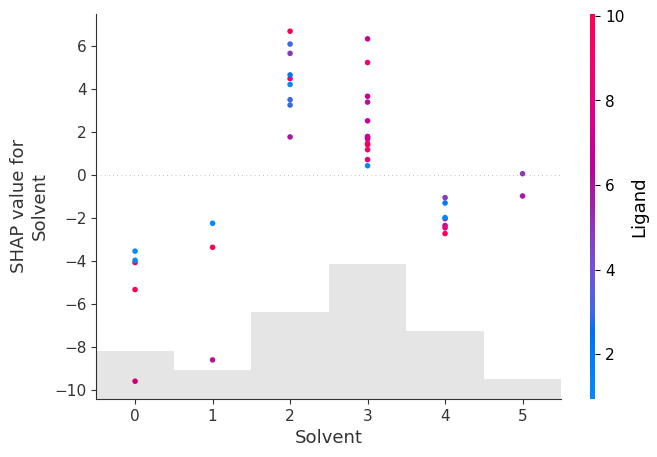

In [11]:
shap.plots.scatter(shap_values[:,"Solvent"], color=shap_values)

DMSO and EtOH lead to the highest yields, again confirmed. DMSO works well with most ligands while EtOH is better with L7, L8, L9...

## Analyzing correlated features

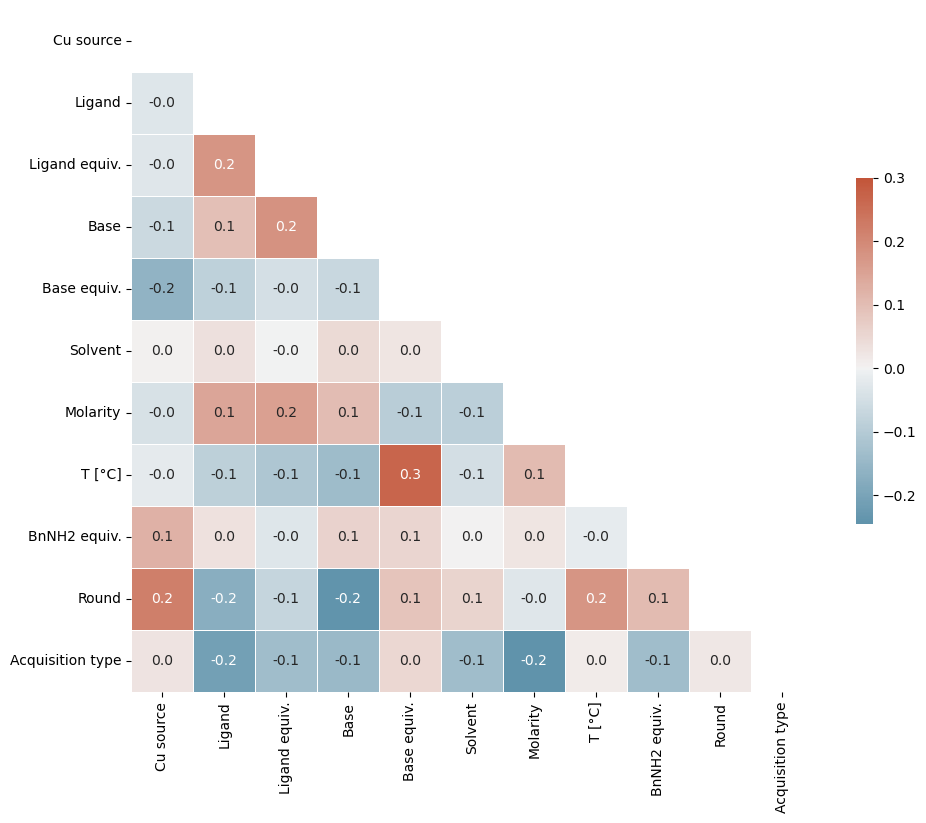

In [12]:
# Compute the correlation matrix
corr = x_train.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
square=True, linewidths=.5, cbar_kws={"shrink": .5},
annot=True, fmt=".1f")
plt.show()

All of these correlations are somewhat weak. The highest is between the base equivalent and the temperature, which chemically speaking, was not so expected. An interaction that was expected but isn't here is solvent/solvent equiv.

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


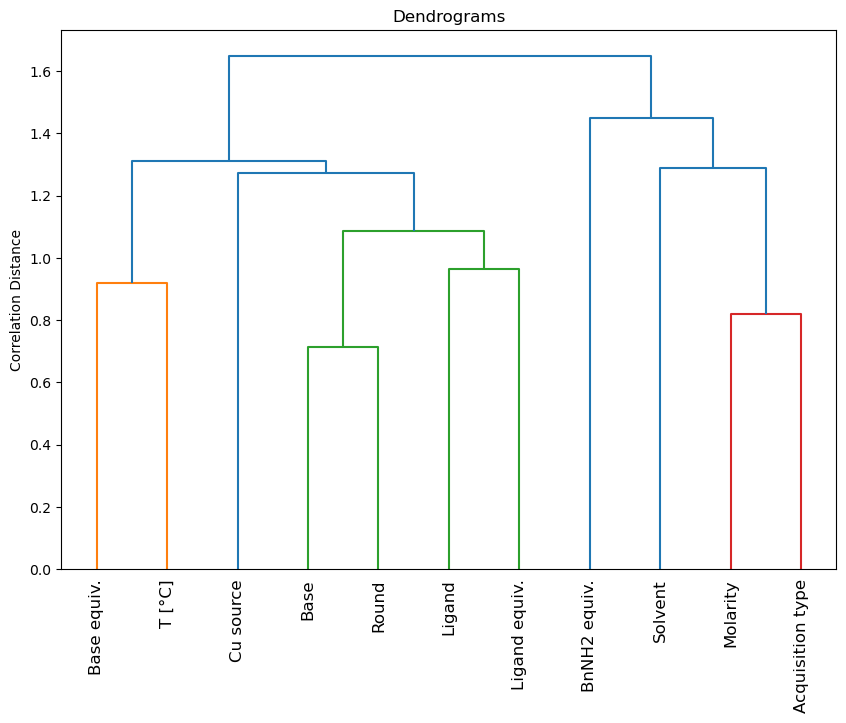

In [13]:
correlation_matrix = x_train.corr()
correlation_matrix = np.corrcoef(correlation_matrix)
correlation_matrix = np.abs(correlation_matrix)
dist_matrix = 1 - correlation_matrix
import scipy.cluster.hierarchy as sch
clustering = sch.linkage(dist_matrix, method="complete")
#clustering = shap.utils.hclust(X_train, metric='correlation')
plt.figure(figsize=(10, 7))
plt.title("Dendrograms")
dend = hierarchy.dendrogram(clustering, labels=x_train.columns)
# Rotate labels for better readability
plt.xticks(rotation=90)
# Increase label size for better visibility
plt.tick_params(axis='x', which='major', labelsize=12)
plt.ylabel('Correlation Distance')
plt.show()

Most clusters are not very explainable chemistry-wise, but one stands out: ligand and ligand equiv. are forked together ! Solvent and molarity are also relatively close. In the same vein, base and base equiv. are part of the same big cluster, but their interaction is very weak.

In [14]:
masker = shap.maskers.Partition(x_train, clustering=clustering)
explainer2 = shap.PartitionExplainer(model.predict, masker)
shap_values2 = explainer2(x_val)

X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fitted with feature names
X does not have valid feature names, but RandomForestRegressor was fit

??? Still works in the end

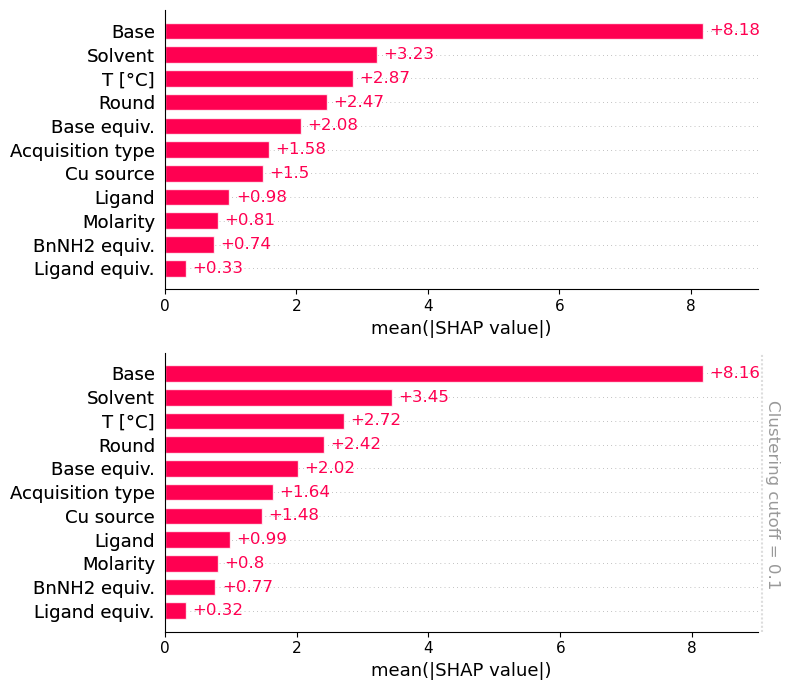

In [20]:
fig = plt.figure(figsize=(6,12))
ax0 = fig.add_subplot(211)
shap.plots.bar(shap_values, max_display=11, show=False)
ax1 = fig.add_subplot(212)
shap.plots.bar(
shap_values2, max_display=11, show=False, clustering_cutoff=0.1
)
plt.tight_layout()
plt.show()

Very little difference between the two

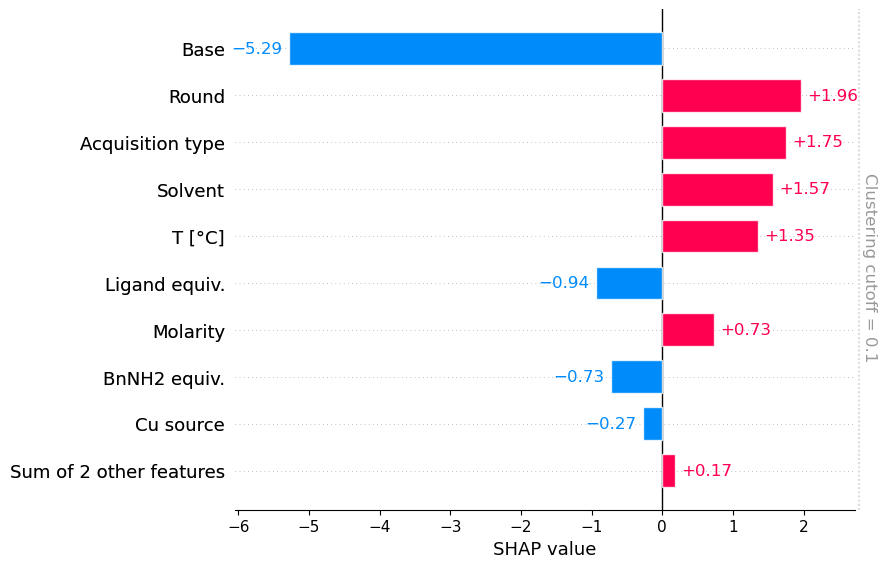

In [21]:
shap.plots.bar(shap_values2[0], clustering_cutoff=0.1)

The correlations are very weak, so it's probably not the best idea to combine these clusters.

In [22]:
explainer_test = shap.Explainer(model, x_train)
shap_values_test = explainer(x_test, check_additivity=False)

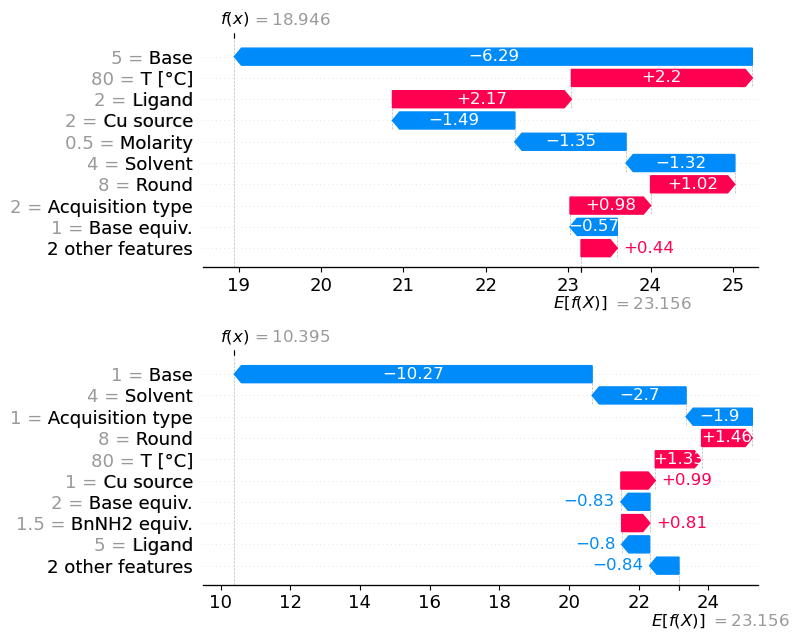

In [23]:
fig = plt.figure(figsize=(6,12))
ax0 = fig.add_subplot(211)
shap.plots.waterfall(shap_values[1], show=False)
ax1 = fig.add_subplot(212)
shap.plots.waterfall(shap_values_test[1], show=False)
plt.tight_layout()
plt.show()

Everything makes sense